### Sentiment Analysis and Topic Modelling

#### FRE9733 - Homework 9

#### Deniz Kural - dk3703

### Steps to follow:
------------------------
i) Download 2000 reviews from the following link:<br>
http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz <br> 
ii) Build a Sentiment Analysis model by comparing two classifiers, and use the better-performed one as the final model <br>
iii) Build a topic model to group the 2000 reviews  <br>
iv) Summarize your finding into a brief report


## Sentiment Analysis

In [1]:
import nltk
import glob
import os
import pandas as pd
import numpy as np
import string

# Modelling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Text preprocessing/analysis
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", context='talk')

#Topic Modelling
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess


C:\Users\deniz\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
file_list = glob.glob(os.path.join(os.getcwd(), r"C:\Users\deniz\Downloads\review_polarity\txt_sentoken\neg", "*.txt"))

corpus_neg = []

for file_path in file_list:
    with open(file_path) as f_input:
        corpus_neg.append(f_input.read())

df_neg=pd.DataFrame(corpus_neg,columns=["Text"])
df_neg["Sentiment"]=0

In [3]:
file_list = glob.glob(os.path.join(os.getcwd(), r"C:\Users\deniz\Downloads\review_polarity\txt_sentoken\pos", "*.txt"))

corpus_pos = []

for file_path in file_list:
    with open(file_path) as f_input:
        corpus_pos.append(f_input.read())
        
df_pos=pd.DataFrame(corpus_pos,columns=["Text"])
df_pos["Sentiment"]=1

In [4]:
df_all=pd.concat([df_pos,df_neg])

In [5]:
df_all.head()

,Text,Sentiment
0,films adapted from comic books have had plenty...,1
1,every now and then a movie comes along from a ...,1
2,you've got mail works alot better than it dese...,1
3,""" jaws "" is a rare film that grabs your atten...",1
4,moviemaking is a lot like being the general ma...,1


In [6]:
df_all.tail()

,Text,Sentiment
995,"if anything , "" stigmata "" should be taken as ...",0
996,"john boorman's "" zardoz "" is a goofy cinematic...",0
997,the kids in the hall are an acquired taste . \...,0
998,there was a time when john carpenter was a gre...,0
999,two party guys bob their heads to haddaway's d...,0


In [7]:
df_all["Sentiment"].value_counts()

0    1000
1    1000
Name: Sentiment, dtype: int64

In [8]:
# Split data into train & test
seed=3
X_train, X_test, y_train, y_test = train_test_split(df_all['Text'], df_all['Sentiment'], test_size=250, random_state=seed, 
                                                    stratify=df_all['Sentiment'])
# Append sentiment back using indices
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [9]:
train.head()

,Text,Sentiment
884,for those interested in the true spirit of mov...,0
343,""" it's not good to know too much about someon...",1
310,i'm not sure if silvio horta wrote urban legen...,0
233,"at times , you'd think edtv would be an entert...",0
677,'pleasantville' ( 1998 ) taps into hollywood's...,1


In [10]:
test.head()

,Text,Sentiment
2,you've got mail works alot better than it dese...,1
0,"plot : two teen couples go to a church party ,...",0
674,look back at all the times in your life when t...,1
789,_dirty_work_ has a premise of deliciously mean...,0
413,there's a scene somewhere in this film where o...,0


### Sentiment Analysis

Method for Sentiment Analysis: VADER 

In [11]:
#Define VADER Sentiment Analysis
sid = SentimentIntensityAnalyzer()
#Apply VADER sentiment analysis to get the polarity for each document in corpus
train[['neg', 'neu', 'pos', 'compound']] = train['Text'].apply(sid.polarity_scores).apply(pd.Series)


In [12]:
train.head()

,Text,Sentiment,neg,neu,pos,compound
884,for those interested in the true spirit of mov...,0,0.092,0.792,0.116,0.8437
343,""" it's not good to know too much about someon...",1,0.129,0.729,0.142,0.8942
310,i'm not sure if silvio horta wrote urban legen...,0,0.153,0.683,0.164,0.8987
233,"at times , you'd think edtv would be an entert...",0,0.166,0.683,0.151,-0.9153
677,'pleasantville' ( 1998 ) taps into hollywood's...,1,0.102,0.770,0.129,0.9884


As we can see from above training example, we have polarity scores such as negative (neg), neutral (neu), positive (pos) and compound score. Compound score is the overall ploarity score that ranges between -1 and 1 where -1 representing the most negative score and 1 representing the most positive score.

We can analyze the results and see if our results match with give polarities from the source. Let's analyze first 10 reviews and their scores with sentiments.

In [13]:
train.nlargest(10, ['pos'])

,Text,Sentiment,neg,neu,pos,compound
144,the dramatic comedy cousins has all the necess...,1,0.030,0.640,0.330,0.9993
542,don't let the following quirks of this review ...,1,0.046,0.629,0.326,0.9983
517,the happy bastard's 30-second review \nnotting...,1,0.057,0.637,0.306,0.9966
751,life is beautiful is a rare treat : a lighthea...,1,0.105,0.597,0.298,0.9989
752,you've probably heard the one about the priest...,1,0.059,0.650,0.291,0.9996
509,as i write the review for the new hanks/ryan r...,1,0.044,0.668,0.288,0.9999
780,note : some may consider portions of the follo...,1,0.038,0.675,0.287,0.9999
587,the happy bastard's quick movie review \nme ta...,1,0.056,0.672,0.272,0.9990
728,playwright tom stoppard and screenwriter marc ...,1,0.065,0.662,0.272,0.9998
355,to paraphrase a song title from an earlier dis...,1,0.035,0.706,0.259,0.9990


In [14]:
train.nlargest(10, ['neg'])

,Text,Sentiment,neg,neu,pos,compound
955,words i thought i'd never write : the sequel t...,0,0.254,0.670,0.077,-0.9979
64,"rated : r for strong violence , language , dru...",0,0.243,0.640,0.117,-0.9989
404,can a horror movie truly be called a horror mo...,0,0.240,0.717,0.044,-0.9987
651,it might surprise some to know that joel and e...,1,0.238,0.688,0.074,-0.9993
747,"edward zwick's "" the siege "" raises more quest...",1,0.231,0.664,0.104,-0.9958
943,this movie stinks ! \nalthough it is professio...,0,0.225,0.728,0.046,-0.9988
761,weighed down by tired plot lines and spielberg...,0,0.224,0.692,0.084,-0.9996
281,the great actor james woods once said ( and i'...,0,0.223,0.636,0.141,-0.9990
248,"vampire's is a rude , chauvinistic movie where...",0,0.222,0.714,0.064,-0.9920
797,i have seen several ( but not that many ) wood...,1,0.219,0.637,0.144,-0.9733


If we compare the sentiments and scores respectively for most positive and negative scores, we can observe that results for positive sentiments are accurately matching but we have some mismatches for most negative score results.

C:\Users\deniz\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


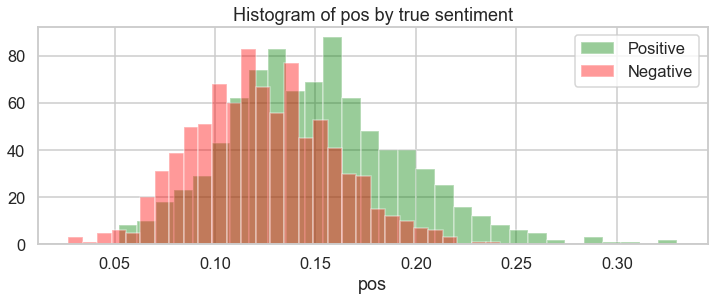

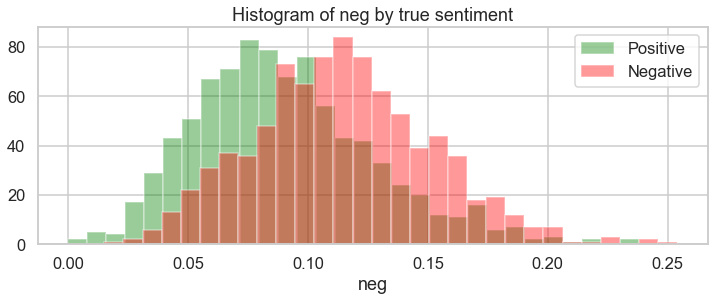

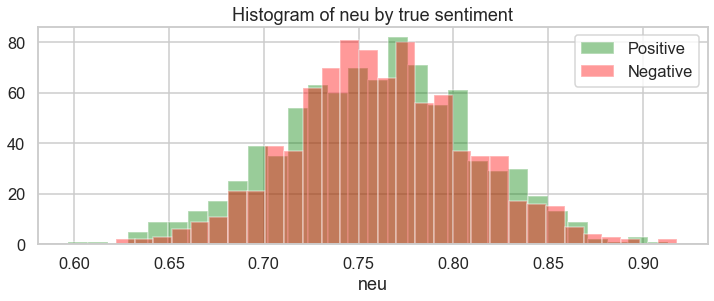

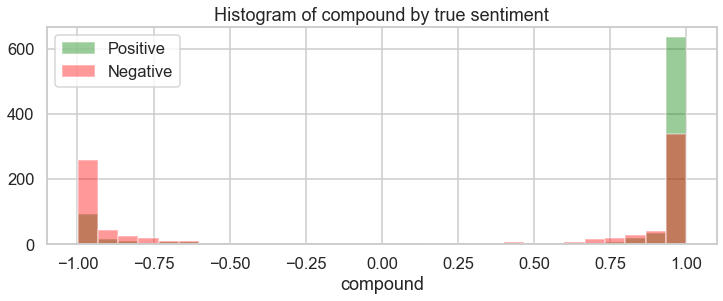

In [15]:
for var in ['pos','neg','neu','compound']:
    
    plt.figure(figsize=(12,4))
    sns.distplot(train.query("Sentiment==1")[var],bins=30,kde=False,color='green',label='Positive')
    sns.distplot(train.query("Sentiment==0")[var],bins=30,kde=False,color='red',label='Negative')
    plt.legend()
    plt.title(f'Histogram of {var} by true sentiment')
    

#### Comments:
   As we can see from above Figures, we can conclude to several results. When we have true positive sentiment ( negative), we have better positive (negative) score that we got from VADER sentiment anaysis. If we look at the distribution for neutral score, we can observe that the overall probability distribution looks uniform for both negative and positive sentiments around 0.75 probability. Lastly, when we look at the compound score probability distribution, we can observe that true negative  sentiments are more than true positive sentiments when we have compound score close to -1 and we have more true positive sentiments than true negative sentiments when we have a compound score close to 1 which was expected. However, these graphs shows us, indeed, we have some errors for finding the true sentiments for documents in our corpus.

### Modelling and Assesing the Results

Selected models for training the data are
- Logistic Regression with 1000 iterations
- Stochastic Gradient Descent Classifier
- Naive Bayes Classifier

To test the results, cross-validation will be applied on the training set and its labels. the default size is 5. We will calciulate the mean score for each metric.

In [16]:
# Define functions
def create_baseline_models():
    """Create list of baseline models."""
    models = []
    models.append(('log', LogisticRegression(random_state=seed, 
                                             max_iter=1000)))
    models.append(('sgd', SGDClassifier(random_state=seed)))
    models.append(('mnb', MultinomialNB()))
    return models

#Assesing the performance of the models
def assess(X, y, models, cv=5, scoring=['roc_auc', 
                                        'accuracy', 
                                        'f1']):
    """Provide summary of cross validation results for models."""
    results = pd.DataFrame()
    for name, model in models:
        result = pd.DataFrame(cross_validate(model, X, y, cv=cv, 
                                             scoring=scoring))
        mean = result.mean().rename('{}_mean'.format)
        std = result.std().rename('{}_std'.format)
        results[name] = pd.concat([mean, std], axis=0)
    return results.sort_index()

In [17]:
#Initialize the models
models = create_baseline_models()

In [18]:
#Function for preprocessing the text with tokenizing, lowercasing and lemmatizing

def preprocess_text(text):
    # 1. Tokenise to alphabetic tokens
    tokeniser = RegexpTokenizer(r'[A-Za-z]+')
    tokens = tokeniser.tokenize(text)
    
    # 2. Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t.lower(), pos='v') 
              for t in tokens]
    return tokens

# Preprocess the data
vectoriser = TfidfVectorizer(analyzer=preprocess_text, 
                             min_df=30, 
                             max_df=.7)
X_train_simple = vectoriser.fit_transform(X_train)
# Assess models
assess(X_train_simple, y_train, models)

,log,sgd,mnb
fit_time_mean,0.056422,0.023499,0.005595
fit_time_std,0.005038,0.001999,0.000555
score_time_mean,0.004395,0.003999,0.005007
score_time_std,0.001518,0.001226,0.001215
test_accuracy_mean,0.838857,0.832000,0.797714
test_accuracy_std,0.023352,0.013613,0.030997
test_f1_mean,0.839019,0.834008,0.790221
test_f1_std,0.025823,0.016242,0.035451
test_roc_auc_mean,0.917460,0.906547,0.890965
test_roc_auc_std,0.011466,0.008695,0.014722


If we look at the results, we can see that logistic regression outperforms and gradient descent classifier outperforms the naive bayes classifier. Log. regression accuracy is a bit better than gradient descent classifier's accuracy. However, the fit time of sgd is almost half of the log. regression which is slight trade-off for log. regression classifier.<br>
We will use SGD classifier as our best model classifier as it has model_loss parameter which allows us to choose between hinge loss and log loss. When we use hinge loss, we are basically using SVM classifier and when we use log loss, we are basically using the logistic regression. We will tune the parameters in next section so that we will find out which loss function is better than the other one.

We will create pipeline in order to tune hyperparameters of our model which comes from tfidfVectorizer and SGD classifier.

In [19]:
# Create a pipeline
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+')),
                 ('model', SGDClassifier(random_state=seed))])
# Prepare a random search
param_distributions = {'vectoriser__min_df': np.arange(10, 1000, 10),
                       'vectoriser__max_df': np.linspace(.2, 1, 40),
                       'model__loss': ['log', 'hinge']}

r_search = RandomizedSearchCV(estimator=pipe, param_distributions=param_distributions, 
                              n_iter=30, cv=5, n_jobs=-1, random_state=seed)
r_search.fit(X_train, y_train)
# Save results to a dataframe
r_search_results = pd.DataFrame(r_search.cv_results_).sort_values(by='rank_test_score')

In [20]:
r_search_results=r_search_results.reset_index(drop=True)

In [21]:
for i in range((10)):
    print(r_search_results.loc[i,'params'])

{'vectoriser__min_df': 10, 'vectoriser__max_df': 0.8358974358974358, 'model__loss': 'log'}
{'vectoriser__min_df': 60, 'vectoriser__max_df': 0.5487179487179488, 'model__loss': 'log'}
{'vectoriser__min_df': 130, 'vectoriser__max_df': 0.9384615384615385, 'model__loss': 'log'}
{'vectoriser__min_df': 140, 'vectoriser__max_df': 0.5076923076923077, 'model__loss': 'log'}
{'vectoriser__min_df': 90, 'vectoriser__max_df': 0.7333333333333334, 'model__loss': 'hinge'}
{'vectoriser__min_df': 230, 'vectoriser__max_df': 0.5487179487179488, 'model__loss': 'log'}
{'vectoriser__min_df': 220, 'vectoriser__max_df': 0.6307692307692307, 'model__loss': 'hinge'}
{'vectoriser__min_df': 180, 'vectoriser__max_df': 0.7743589743589743, 'model__loss': 'hinge'}
{'vectoriser__min_df': 380, 'vectoriser__max_df': 0.7538461538461538, 'model__loss': 'log'}
{'vectoriser__min_df': 350, 'vectoriser__max_df': 0.7538461538461538, 'model__loss': 'log'}


In [22]:
r_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vectoriser__min_df,param_vectoriser__max_df,param_model__loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.002445,1.412767,1.354075,0.220280,10,0.835897,log,"{'vectoriser__min_df': 10, 'vectoriser__max_df...",0.868571,0.820000,0.834286,0.851429,0.880000,0.850857,0.021864,1
1,3.303917,0.513205,0.981507,0.290131,60,0.548718,log,"{'vectoriser__min_df': 60, 'vectoriser__max_df...",0.862857,0.814286,0.800000,0.811429,0.825714,0.822857,0.021609,2
2,4.613035,1.597413,0.828258,0.119251,130,0.938462,log,"{'vectoriser__min_df': 130, 'vectoriser__max_d...",0.802857,0.785714,0.768571,0.768571,0.797143,0.784571,0.014182,3
3,5.906091,1.548228,1.152995,0.610932,140,0.507692,log,"{'vectoriser__min_df': 140, 'vectoriser__max_d...",0.774286,0.777143,0.777143,0.788571,0.774286,0.778286,0.005299,4
4,5.722708,0.860131,1.084719,0.429016,90,0.733333,hinge,"{'vectoriser__min_df': 90, 'vectoriser__max_df...",0.785714,0.765714,0.782857,0.765714,0.785714,0.777143,0.009390,5


For our best model, we have selected SGD classifier with log loss which is simply equal to logistic regression and we have selected vectoriser with min_df=10 and max_df=.85 where min_df represents the removel of tokens that appear less than 10 documents and max_df represents the removal of tokens that appear more than 85% of the documents.

In [23]:
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+', min_df=10, max_df=.85)),
                 ('model', SGDClassifier(random_state=seed, loss='log'))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(max_df=0.85, min_df=10,
                                 token_pattern='[a-z]+')),
                ('model', SGDClassifier(loss='log', random_state=3))])

In [24]:
target=['negative', 'positive']

#### Interpret and Assess the Results:

In [25]:
train_pred = pipe.predict(X_train)
print(classification_report(train_pred, 
                            y_train, 
                            target_names=target))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       871
    positive       1.00      1.00      1.00       879

    accuracy                           1.00      1750
   macro avg       1.00      1.00      1.00      1750
weighted avg       1.00      1.00      1.00      1750



In [26]:
test_pred = pipe.predict(X_test)
print(classification_report(test_pred, 
                            y_test, 
                            target_names=target))

              precision    recall  f1-score   support

    negative       0.85      0.92      0.88       115
    positive       0.93      0.86      0.89       135

    accuracy                           0.89       250
   macro avg       0.89      0.89      0.89       250
weighted avg       0.89      0.89      0.89       250



When we analyze the results above, we can see that there is slightly overfitting of the model as we can see the difference of accuracy between test and training sets. However, we get quite good results. We are able to predict with 89% accuracy in out of sample dataset which is quite good.

## Topic Modelling

Now, we will implement topic modelling for given 2000 documents to see topic distribution to see and understand the structure of the documents better. To do that, we will implement  Latent Dirichlet Allocation (LDA) model.

In [27]:
#We will use text from df_all["Text"]
df_all.head()

,Text,Sentiment
0,films adapted from comic books have had plenty...,1
1,every now and then a movie comes along from a ...,1
2,you've got mail works alot better than it dese...,1
3,""" jaws "" is a rare film that grabs your atten...",1
4,moviemaking is a lot like being the general ma...,1


In [28]:
#Data Cleaning

# Remove punctuation
df_all['Text_processed'] = \
df_all['Text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df_all['Text_processed'] = \
df_all['Text'].map(lambda x: x.lower())
df_all['Text_processed'] = \
df_all['Text'].map(lambda x:  "".join([char for char in x if char not in string.punctuation]))
# Print out the first rows of papers
df_all['Text_processed'].head()

0    films adapted from comic books have had plenty...
1    every now and then a movie comes along from a ...
2    youve got mail works alot better than it deser...
3      jaws  is a rare film that grabs your attenti...
4    moviemaking is a lot like being the general ma...
Name: Text_processed, dtype: object

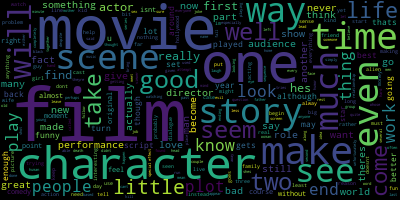

In [29]:
# Join the different processed titles together.
long_string = ','.join(list(df_all['Text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=5000, contour_width=4, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

When we analyze the word cloud, we face with an expected result. What I mean is that the most common words are movie, character, scene, story, etc. which are all related to cinema industry and as we have movie review documents, we expect topics that are related to this industry.

In [30]:
#Preprocess for LDA  Model
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','br','one','also','much','two','would','could','dont','doesnt'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = df_all['Text_processed'].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deniz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['films', 'adapted', 'comic', 'books', 'plenty', 'success', 'whether', 'theyre', 'superheroes', 'batman', 'superman', 'spawn', 'geared', 'toward', 'kids', 'casper', 'arthouse', 'crowd', 'ghost', 'world', 'theres', 'never', 'really', 'comic', 'book', 'like', 'hell', 'starters', 'created', 'alan']


At this preprocessing stage for LDA model, we remove stopwords such as 'the,a,and,... etc.' from the tokenzied word list. To token or to split each doucment into words, we use the given functions above. Also, while seperating the documents into words, we salso get rid of punctuations as they don't show any importance for LDA topic modelling model. First 30 words of first document can be observed above result.

Now, we want to find the frequency of each word in the corpus we have that includes 2000 documents. To do that we need to firstly create dictipnary from our word list. Then, we apply 'doc2bow' function in order to find out term frequency in every doucments.

In [31]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


**Train LDA model and find out the most important keywords in each topic created.**

In [32]:
#LDA Model Training
from pprint import pprint
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"film" + 0.010*"movie" + 0.005*"like" + 0.003*"good" + 0.003*"even" + '
  '0.003*"get" + 0.003*"time" + 0.003*"story" + 0.003*"characters" + '
  '0.002*"scene"'),
 (1,
  '0.013*"film" + 0.007*"movie" + 0.005*"like" + 0.003*"good" + 0.003*"even" + '
  '0.003*"first" + 0.003*"time" + 0.003*"films" + 0.003*"story" + '
  '0.002*"characters"'),
 (2,
  '0.011*"film" + 0.006*"like" + 0.006*"movie" + 0.004*"even" + 0.003*"films" '
  '+ 0.003*"time" + 0.003*"good" + 0.003*"characters" + 0.003*"story" + '
  '0.003*"well"'),
 (3,
  '0.012*"film" + 0.007*"movie" + 0.004*"like" + 0.004*"even" + 0.003*"story" '
  '+ 0.003*"good" + 0.003*"time" + 0.003*"films" + 0.003*"characters" + '
  '0.003*"well"'),
 (4,
  '0.014*"film" + 0.008*"movie" + 0.005*"like" + 0.004*"character" + '
  '0.003*"even" + 0.003*"time" + 0.003*"good" + 0.003*"story" + 0.003*"see" + '
  '0.003*"films"')]


As can be observed from above result, each topic seems to have very similar keywords to represent themselves. This was an expected result as we have same source for all documents that is movie reviews and this means that they share same topic. However, LDA tries to diferentiate and create different topics even if the topics are same for all documents. For instance, there could be differentiation regarding movie genres and places that movie is held.

In [34]:
#LDA Visualization
import pyLDAvis.gensim_models
lda_visualization = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.display(lda_visualization)

C:\Users\deniz\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


We see 5 circles at the top which shows us how different each topic from each other. Indeed, we can cocnlude that they are quiet seperated frome ach other and the selection of topic size that is 45 seems appropiate. Some of the comments that we can make from above visualization: <br> <br>
i) We see the most salient words in the documents we have, and when we examine each word occurance in each topic, we can see that each word occurs in each topic. So, this shows us that again, the topics have common properties and basically about movie reviews and movie industry norms.<br> <br>
ii) When we click the topics, we can also observe the occurance rate of most salient words in these topics. When we examine each topic,we can see that top 5 most salient words in each topic are almost the same. Moreover, if we read through all list for all of the topics, we can observe that they have lots of common salient words appearing in their lists in different orders. 